<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/PeriodicBarriers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import sympy as sp


clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [3]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

Load pre-defined functions from GitHub


# Working on the mesh

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


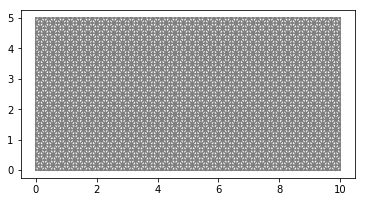

In [4]:
a = 10;
p0=Point(0,0,0)
p1=Point(a,1,1)
nx, ny, nz = int(5*a), 5, 5
#mymesh = BoxMesh(p0, p1, nx, ny, nz);
mymesh = RectangleMesh(Point(0,0), Point(a, a/2), 70, 30, "right/left")
plot(mymesh)


# Solve the Bloch-Torrey equation

In [13]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [1000]

for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                              # bvalue
    mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 


    mri_para.Apply()
    mri_simu.k = 100;                                    # time-step size
    mri_simu.nskip = 200;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = None
    mydomain.PeriodicDir = [1, 0, 0];             # Direction of the periodicity
    mydomain.IsDomainPeriodic = False              # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
    ################################################################################
    mydomain.kappa_e_scalar = 0.005;
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D0 = 3e-3
    mydomain.D = mydomain.D0;
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")

    mri_simu.solve(mydomain, mri_para, linsolver)

    ctext = ""
    if bvalue==1000:
        ctext = "3D realistic neuron, kcoeff=3e-3, delta=10600us, Delta=43100us, dt=200us, gdir=200"
    Post_processing(mydomain, mri_para, mri_simu, None, ctext)

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
The pseudo-periodic BCS are weakly imposed.
The mesh does not need to be periodic.
t:   0.00  T: 53700.00 dt: 100.0 gnorm: 1.499786e-05 Completed 0.00%
t: 20000.00  T: 53700.00 dt: 100.0 gnorm: 1.499786e-05 Completed 37.17%
t: 40000.00  T: 53700.00 dt: 100.0 gnorm: 1.499786e-05 Completed 74.35%
Successfully Completed! Elapsed time: 33.369709 seconds
b: 1000.000, q: 0.056, Signal: 2.012e+00, Normalized signal: 4.024e-02, dt: 100.000, hmin: 2.195e-01, whole_vol: 50.000, vol_of_interest: 50.000, Free signal: 4.979e-02, elasped time 33.370 (s)

rank:  0
save to log.txt
